# CUSTOMER BEHAVIOR ANALYSIS

Customer behavior analysis is a vital process that can provide businesses with valuable insights into their customers' behaviors and preferences. In this project, we will be analyzing the CDNOW dataset to determine customer buying patterns based on Recency, Frequency, and Monetary Value (RFM).

**-** Using Python, we will perform RFM analysis to determine each customer's Recency, Frequency, and Monetary Value based on their transaction history. This analysis will help us understand how recently and how often customers make purchases, as well as the average amount they spend.

**-** Next, we will use the K-Means algorithm to segment customers into groups based on their RFM scores. This segmentation will help us identify distinct customer groups and tailor marketing strategies and promotions to each group's specific needs and preferences.

**-** We will also predict the probability of customer spending and the likelihood of their purchase using XGBRegressor and XGBClassifier. By predicting customer behavior, businesses can better understand their customers' needs and preferences and adjust their marketing strategies accordingly.

**-** Finally, we will conduct cohort analysis to determine customer lifetime value (CLV) and measure the effectiveness of our marketing strategies. By analyzing customer behavior over time, we can gain insights into how our customer base changes and adapt our strategies to meet their evolving needs.

Overall, this project will provide valuable insights into customer behavior, allowing businesses to improve customer engagement, retention, and revenue.


In [1]:
# import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline
from sklearn import preprocessing
import joblib
import plydata.cat_tools as cat
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv("cdnow.csv")

## Customer Segmentation 

We segment the customers into groups of certain similarities to get a broad view of customers spread. Then we can begin to answer some business questions

In [3]:
df = df.assign(date = lambda x: pd.to_datetime(x["date"])).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   69659 non-null  int64         
 1   customer_id  69659 non-null  int64         
 2   date         69659 non-null  datetime64[ns]
 3   quantity     69659 non-null  int64         
 4   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.7 MB


In [4]:
df.drop("Unnamed: 0",axis=1, inplace = True)

### RFM Analysis

RFM analysis is a marketing technique used to analyze customer behavior based on three factors: 
Recency, Frequency, and Monetary value of purchases. 
It helps businesses identify their most valuable customers and design targeted marketing 
strategies.

In [5]:
#make recency(OrderDate) from behind data

max_date = df["date"].max()

In [6]:
recency_features_df = df[["customer_id", "date"]] \
        .groupby("customer_id") \
        .apply(lambda x: (x["date"].max()-max_date) / pd.to_timedelta(1, "day")) \
        .to_frame().set_axis(["recency"], axis=1)


In [7]:
#Make price (MonetaryValue) features from lower data

price_feature_df = df[["customer_id","date","price"]] \
        .groupby("customer_id") \
        .aggregate( {"price": "sum"}) \
        .set_axis(["money_value"],axis=1)

In [8]:
# Make Frequency (count) features from lower data

frequency_features_df = df[["customer_id","date"]] \
        .groupby("customer_id") \
        .count() \
        .set_axis(["frequency"], axis=1)

In [9]:
# Combine features

rfm_df = pd.concat([recency_features_df,frequency_features_df,price_feature_df],axis=1) 

In [10]:
rfm_df.head(3)

,recency,frequency,money_value
customer_id,,,
1,-545.0,1,11.77
2,-534.0,2,89.00
3,-33.0,6,156.46


### K-Means Clustering

In [11]:
# scale the dataframe
scaler = StandardScaler()
scaled_df = scaler.fit_transform(rfm_df)

First, we run a range of different K-values to find the optimal K

In [12]:
inertia = []
val_range = range(1,11)
for i in val_range:
    kmean = KMeans(n_clusters=i)
    kmean.fit(pd.DataFrame(scaled_df))
    inertia.append(kmean.inertia_)

inertia

[70709.99999999994,
 41170.076154314804,
 27158.24888288765,
 18061.018831061745,
 13971.250214546948,
 11641.263198850851,
 9971.319300013189,
 8647.475217968538,
 7784.720600877558,
 7130.534375570369]

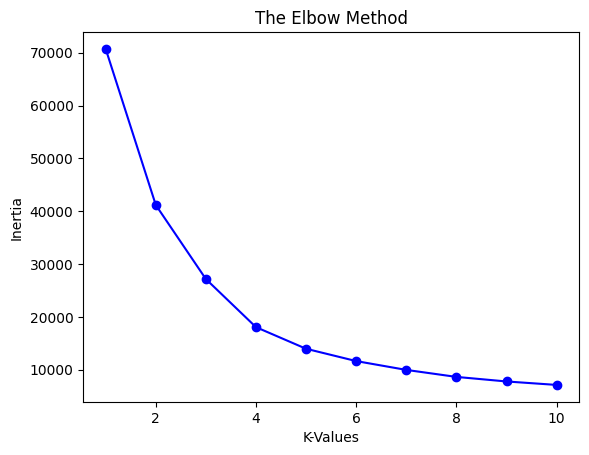

In [13]:
plt.plot(val_range,inertia,'bo-')
plt.xlabel('K-Values') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method') 
plt.show()

 Initializes a KMeans object with optimum K-value (K=5) 

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)           
kmeans.fit_predict(scaled_df)         
labels = kmeans.labels_
kmeans.inertia_

18061.028084283418

Let's plot view the clusters using PCA.
We use PCA to reduce the number of dimensions,i.e, the number of columns down to two. 

In [15]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_components ,columns=["PCA1","PCA2"])
pca_df

,PCA1,PCA2
0,-0.973699,0.574309
1,-0.616463,0.715440
2,1.427873,-1.347354
3,0.573200,-0.755073
4,2.284039,0.016922
...,...,...
23565,-0.690681,0.224453
23566,-0.728486,0.196347
23567,-0.133107,0.349569
23568,-0.716488,0.205267


In [16]:
pca_df["cluster"] = labels
pca_df

,PCA1,PCA2,cluster
0,-0.973699,0.574309,0
1,-0.616463,0.715440,0
2,1.427873,-1.347354,1
3,0.573200,-0.755073,1
4,2.284039,0.016922,1
...,...,...,...
23565,-0.690681,0.224453,0
23566,-0.728486,0.196347,0
23567,-0.133107,0.349569,0
23568,-0.716488,0.205267,0


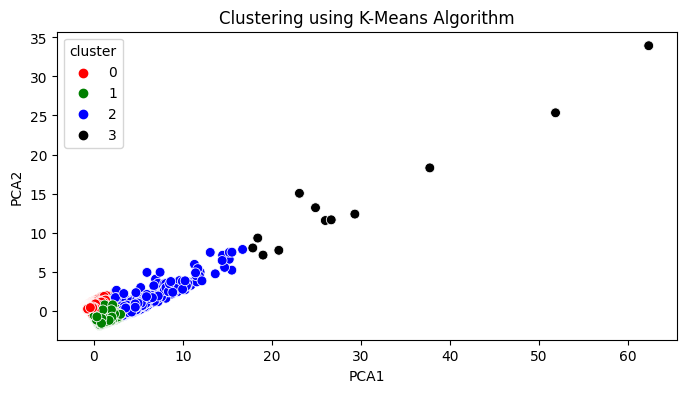

In [17]:
# plot the clusters
plt.figure(figsize=(8,4))
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="cluster", data=pca_df, \
                     palette=['red', 'green', 'blue', 'black'], s=50)
plt.title("Clustering using K-Means Algorithm")
plt.show()

In [18]:
# add the the labels to rfm_df to see each customer and their corresponding label/group.
clustered_df = rfm_df.copy()
clustered_df["cluster"] = labels

In [19]:
# check the mean of each feature for each group
clustered_df.groupby("cluster").mean()

,recency,frequency,money_value
cluster,,,
0,-483.431710,1.378380,42.867019
1,-129.206787,4.875435,164.788387
2,-59.056851,18.438776,885.288207
3,-48.833333,114.000000,5731.975833


In [20]:
def get_status(row):
    if row["cluster"] == 0:
        return "Losing"
    elif row["cluster"] == 1:
        return "average"
    elif row["cluster"] == 2:
        return "loyal"
    else:
        return "VIP"
      
clustered_df["Cus_status"] = clustered_df.apply(get_status,axis=1)

In [21]:
clustered_df = clustered_df.reset_index()
clustered_df.head(3)

,customer_id,recency,frequency,money_value,cluster,Cus_status
0,1,-545.0,1,11.77,0,Losing
1,2,-534.0,2,89.00,0,Losing
2,3,-33.0,6,156.46,1,average


In [22]:
clustered_df["Cus_status"].value_counts()

Losing     15976
average     6896
loyal        686
VIP           12
Name: Cus_status, dtype: int64

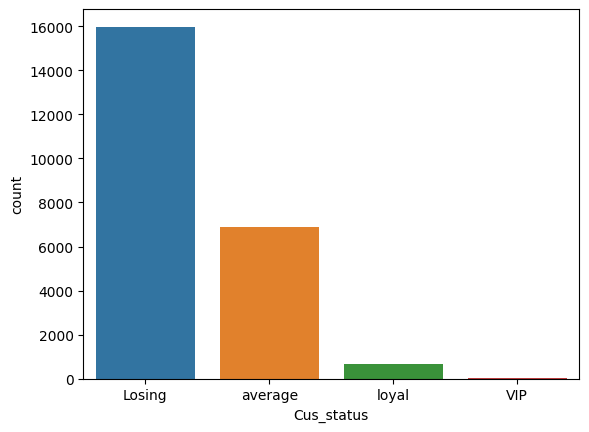

In [23]:
sns.countplot(x='Cus_status', data=clustered_df)
plt.show()

**Now we have identified different groups to which each customer belong and can therefore develop specific marketing strategies suitable for each group.**

**However, We can further refine our dataset to obtain specific insights such as identifying the customer with the highest spend probability, predicting a customer's potential spending amount, recognizing missed opportunities, identifying customers who have made recent purchases but are unlikely to make more.
These insights can support further investigations that generate meaningful information crucial for creating a successful and targeted marketing campaign.**

## Machine learning

##### -What the customers spend in the next 90 days?(regression)
##### -What is the probability of a customer to make a purchase in the next 90 days?(classification)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


In [25]:
# visualize: individual customer purchases

ids = np.random.choice(df["customer_id"],20)
#selected_ids = ids[0:12]
#selected_ids
ids

array([23526,    65,  1160,  8897, 12146,  7786, 16729, 15871,   729,
       11748, 10851, 20137,  6674, 18235,  1078, 14600,  2757, 18634,
        6051, 17374])

In [26]:
cust_id_subset_df = df[df["customer_id"].isin(ids)] \
                    .groupby (["customer_id", "date"]) \
                    .sum() \
                    .reset_index()

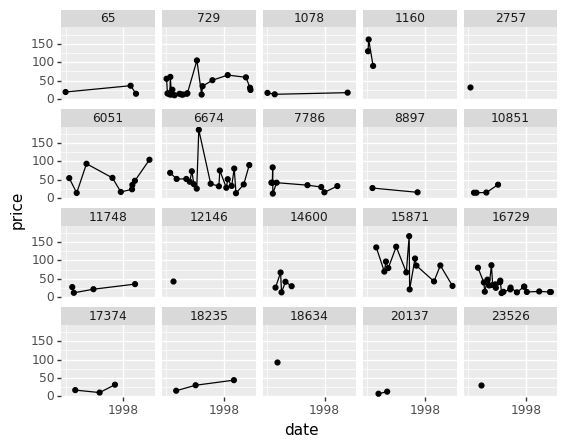

<ggplot: (8726816129883)>

In [27]:
# create the plot
(pn.ggplot(
    data=cust_id_subset_df,
    mapping=pn.aes(x="date", y="price", group="customer_id")) 
    + pn.geom_line() 
    + pn.geom_point() 
    + pn.facet_wrap("customer_id") 
    + pn.scale_x_date(date_breaks="2 year", date_labels="%Y")
)

In [28]:
n_days = 90
max_order_date = df["date"].max() 
cutoff = max_order_date - pd.to_timedelta(n_days, unit="d")

In [29]:
temporal_behind_df = df[df["date"] <= cutoff]
temporal_ahead_df = df[df["date"] >= cutoff]

In [30]:
temporal_ahead_df.head()

,customer_id,date,quantity,price
8,3,1998-05-28,1,16.99
38,9,1998-06-08,2,41.98
68,25,1998-04-17,1,12.99
69,25,1998-05-25,1,10.49
70,25,1998-06-03,3,24.97


In [31]:
# make target from higher data
targets_df = temporal_ahead_df.drop("quantity", axis=1).groupby("customer_id").sum() \
    .rename({"price":"spend_90_total"}, axis=1) \
    .assign(spend_90_flag = 1)

In [32]:
targets_df.head()

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1


In [33]:
#make recency(OrderDate) from behind data

max_date = temporal_behind_df["date"].max()

In [34]:
recency_features_df = temporal_behind_df[["customer_id", "date"]] \
        .groupby("customer_id") \
        .apply(lambda x: (x["date"].max()-max_date) / pd.to_timedelta(1, "day")) \
        .to_frame().set_axis(["recency"], axis=1)


In [35]:
#recency_features_df.head()

In [36]:
# Make Frequency (count) features from lower data

frequency_features_df = temporal_behind_df[["customer_id","date"]] \
        .groupby("customer_id") \
        .count() \
        .set_axis(["frequency"], axis=1)

In [37]:
#Make price (MonetaryValue) features from lower data

price_feature_df = temporal_behind_df[["customer_id","date","price"]] \
        .groupby("customer_id") \
        .aggregate( {"price": ["sum","mean"]}) \
        .set_axis(["Sales_sum","Sales_mean"],axis=1)

In [38]:
# Combine features

Features_df = pd.concat([recency_features_df,frequency_features_df,price_feature_df],axis=1) \
              .merge(targets_df,
               left_index=True,
               right_index = True,
               how = "left") \
            .fillna(0)

In [39]:

Features_df.head()

,recency,frequency,Sales_sum,Sales_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0


In [40]:
X = Features_df[["recency","frequency","Sales_sum","Sales_mean"]]

In [41]:
#nwxt 90-days
y_spend = Features_df["spend_90_total"]

In [42]:
xgb_reg_spec2 = XGBRegressor(
    objective="reg:squarederror",
    random_state=123
)

param_grid = {
    "learning_rate": [0.01, 0.1, 0.3, 0.5]
}

xgb_reg_model2 = GridSearchCV(
    estimator=xgb_reg_spec2,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

xgb_reg_model2.fit(X,y_spend)




GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1, param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [43]:
# Print the best parameters and best score
print(f"Best parameters: {xgb_reg_model2.best_params_}")
print(f"Best score: {xgb_reg_model2.best_score_}")


Best parameters: {'learning_rate': 0.01}
Best score: -9.782938524056352


In [44]:
y_pred = xgb_reg_model2.predict(X)

In [45]:
y_pred[:10]

array([ 0.7684548,  1.6811874,  9.103387 ,  7.5565157, 15.197543 ,
        0.8081817, 17.22487  , 19.520144 ,  2.426112 ,  0.8504526],
      dtype=float32)

In [46]:
# Next 90-days spend probability

y_prob = Features_df["spend_90_flag"]

In [47]:
# Define the XGBClassifier with some initial hyperparameters
from sklearn.metrics import roc_auc_score
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    max_depth=5,
    subsample=0.75,
    colsample_bytree=0.75,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=123
)

# Fit the model on the training data
xgb_clf.fit(X, y_prob)

# Evaluate the model on the test data
y_pred = xgb_clf.predict_proba(X)[:, 1]
auc_score = roc_auc_score(y_prob, y_pred)
print("ROC AUC score: {:.4f}".format(auc_score))

ROC AUC score: 0.8765


In [48]:
y_pred_prob = xgb_clf.predict_proba(X)


In [49]:
print("ROC AUC score: {:.4f}".format(auc_score))

ROC AUC score: 0.8765


## Feature Importance

In [50]:
# Importance | Spend Amount Model

imp_spend_amount_dict = xgb_reg_model2 \
    .best_estimator_ \
    .get_booster() \
    .get_score(importance_type="gain")

In [51]:

# Create a pandas DataFrame from a dictionary of important spending amounts
imp_spend_amount_df = pd.DataFrame({
    "features": list(imp_spend_amount_dict.keys()),
    "value": list(imp_spend_amount_dict.values())
})

# Reorder the "features" column based on the corresponding "value" column
imp_spend_amount_df = imp_spend_amount_df.assign(
    features=lambda df: cat.cat_reorder(df["features"], df["value"])
)

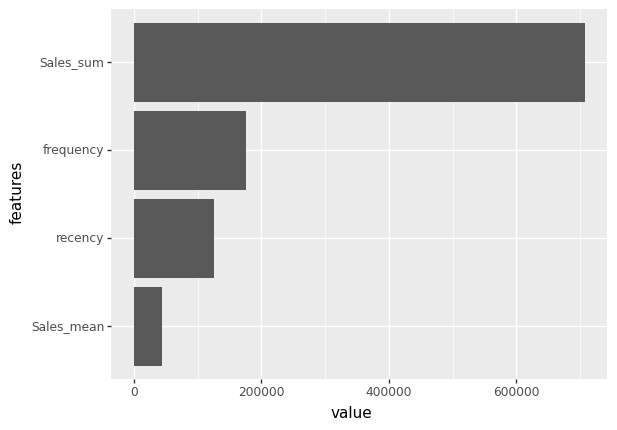

<ggplot: (8726742700861)>

In [52]:
(pn.ggplot(
    data = imp_spend_amount_df,
    mapping = pn.aes("features","value")) \
    + pn.geom_col() \
    + pn.coord_flip()
)


In [53]:
importance_scores = xgb_clf.feature_importances_
feature_names = X.columns # Assuming X is a pandas DataFrame
sorted_idx = importance_scores.argsort()

imp_spend_prob_df = pd.DataFrame({
    "features": feature_names[sorted_idx],
    "value": importance_scores[sorted_idx]
})

# Reorder the "features" column based on the corresponding "value" column
imp_spend_prob_df = imp_spend_prob_df.assign(
    features=lambda df: cat.cat_reorder(df["features"], df["value"])
)


In [54]:
imp_spend_amount_df.value_counts(normalize=True)

features    value        
Sales_mean  43371.421875     0.25
recency     125266.851562    0.25
frequency   175807.296875    0.25
Sales_sum   707378.750000    0.25
dtype: float64

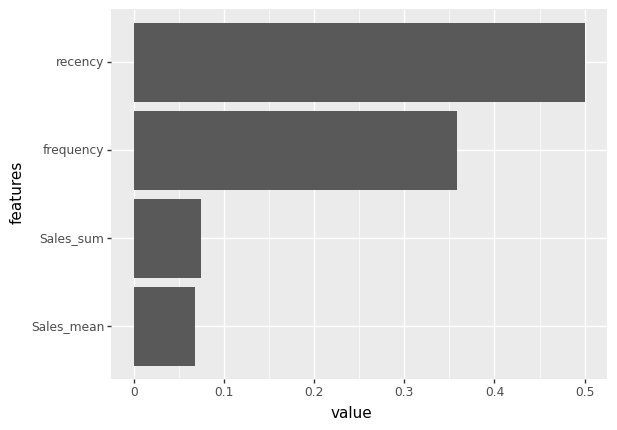

<ggplot: (8726742722765)>

In [55]:
(pn.ggplot(
    data = imp_spend_prob_df,
    mapping = pn.aes("features","value")) \
    + pn.geom_col() \
    + pn.coord_flip()
)

In [56]:
# Save Predictions

predictions_df = pd.concat(
    [
        Features_df.reset_index(),
        pd.DataFrame(y_pred ).set_axis(["spend_pred"],axis=1), \
        pd.DataFrame(y_pred_prob)[[1]].set_axis(["spend_prob"],axis=1), \
        
    ],
    axis=1
)


In [57]:
age_df = data.groupby("customer_id").agg(
      {"date": lambda x: (data["date"].max() - x.min()).days})

NameError: name 'data' is not defined

In [ ]:
# merge predictions_df and df2 (CLV dataframe)
merged_df = pd.merge(predictions_df,df2, on='customer_id')

# drop the specified columns
merged_df = merged_df.drop(columns=['quantity', 'total_revenue', 'num_transactions', \
                                    'AOV', 'profit_margin']).rename({"age": "customer_duration"})

# print the resulting dataframe
merged_df.head()

In [ ]:
#save 

#predictions_df.to_pickle("artifacts/predictions_df.pkl")

#pd.read_pickle("folderName/predictions_df.pkl")

In [ ]:
#load model
#model = joblib.load("folderName/xgb_clf_model")
#model.predict(X)

**#Question 1:** 
which customers have the highest spend probability in the next 90 days?
- Target for new products similar to what they have pruchased in the past.

In [ ]:
Highest_prob_df =predictions_df.sort_values("spend_prob", ascending = False )
Highest_prob_df

**#Question 2: Which customers have recently purchased but are unlikely to buy?**
- Incentivize actions to increase probability
- Provide didcounts, encourage referring a friend, nuture by letting them know what's coming.

In [ ]:
merged_df[merged_df["recency"] > -90] \
    [
    merged_df["spend_prob"] < 0.20
    ] \
    [
    merged_df["age"] >= 520
    ] \
    .sort_values("spend_prob", ascending=False)

**#Question 3:** Missed opportunities: We could unlock Big spenders 
- Send bundle offers  encouraging volume purchases 
- Focus on missed opportunities

In [ ]:
merged_df[merged_df["spend_90_total"]== 0.0].sort_values("spend_pred", ascending= False)

In [ ]:
# Investigate clusters

cluster_0 = clustered_df[clustered_df["cluster"]==0]["customer_id"].unique()
cluster_1 = clustered_df[clustered_df["cluster"]==1]["customer_id"].unique()
cluster_2 = clustered_df[clustered_df["cluster"]==2]["customer_id"].unique()
cluster_3 = clustered_df[clustered_df["cluster"]==3]["customer_id"].unique()



cust_id_subset_df = merged_df[merged_df["recency"] < -90] \
    [
    merged_df["spend_prob"] >= 0.30
    ] \
    [
    merged_df["customer_id"].isin(cluster_0)
    ] \
    .sort_values("spend_prob", ascending=False)


cust_id_subset_df

# Cohort Analysis